## Import Packages

In [89]:
# Web - Scraping and API Requests
import requests
from httpx import AsyncClient, Response
from parsel import Selector
import parsel
import jmespath
import asyncio

# Data Manipulation and Analysis
import pandas as pd
from pprint import pprint 
import json
from typing import List
from typing import TypedDict

# Data Visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Regressions
from sklearn.linear_model import LinearRegression


# Database Connection
from sqlalchemy import create_engine
from sqlalchemy import inspect, text

# File and System Operations
import os
import sys

## Other Setup

In [90]:
# This allows one to reload the custom package without having to install it again
%load_ext autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# this allows one to reload the custom package without having to install it again
%autoreload 1

sys.path.insert(0,'../src/')

# Import the custom package and sub-packages
%aimport rental_utils
%aimport rental_utils.functions
%aimport rental_utils.sql_queries

In [92]:
pd.set_option('display.max_columns', None) # Display all columns in any given DataFrame

### Import Custom Packages

In [93]:
from rental_utils import sql_queries as sqlq
from rental_utils import functions as rent

## Analyse the Data

### Get the Data from the Database

In [94]:
engine = sqlq.get_sql_engine("../data/properties.db")

In [95]:
with engine.connect() as connection:
    properties_data = pd.read_sql(text(sqlq.GET_PROPERTIES_DATA_SQL_QUERY), connection)

#### Filter out Only Monthly Contracts

In [96]:
reg_data = properties_data[properties_data["priceFrequency"] == "monthly"]
reg_data = reg_data[pd.to_numeric(reg_data["price_per_bed"], errors="coerce").between(100, 10000)]
reg_data.head()

,id,distance,travel_time,price_per_bed,predicted_price_per_bed,bedrooms,bathrooms,numberOfImages,displayAddress,latitude,longitude,propertySubType,listingUpdateReason,listingUpdateDate,priceAmount,priceFrequency,premiumListing,featuredProperty,transactionType,students,displaySize,propertyUrl,firstVisibleDate,addedOrReduced,propertyTypeFullDescription
0,163986251,0,1105,5200.000000,None,1,1,6,"Wardour Street, Soho, Soho, London, W1F",51.512776,-0.133739,Flat,new,2025-06-30T19:04:02Z,5200,monthly,0,0,rent,0,38 sq. m.,/properties/163986251#/?channel=RES_LET,2025-06-30T18:58:59Z,Added today,1 bedroom flat
1,163986410,0,2957,900.000000,None,2,1,10,"Torrington Park, London, N12",51.617160,-0.165010,Flat,new,2025-06-30T19:31:03Z,1800,monthly,0,0,rent,0,,/properties/163986410#/?channel=RES_LET,2025-06-30T19:25:46Z,Added today,2 bedroom flat
2,163986269,0,1426,2000.000000,None,1,1,7,"Clanricarde Gardens, Notting Hill, London, W2",51.510832,-0.193993,Flat,new,2025-06-30T19:05:02Z,2000,monthly,0,0,rent,0,33 sq. m.,/properties/163986269#/?channel=RES_LET,2025-06-30T18:59:24Z,Added today,1 bedroom flat
3,163986176,0,1330,2699.000000,None,1,1,14,"Westfield Avenue, London, E20",51.541640,-0.007200,Apartment,new,2025-06-30T19:03:22Z,2699,monthly,1,0,rent,0,,/properties/163986176#/?channel=RES_LET,2025-06-30T18:57:24Z,Added today,1 bedroom apartment
4,163986587,0,839,1666.666667,None,3,2,7,"Cranfield House, 97-107 Southampton Row, Bloom...",51.520950,-0.123693,Apartment,new,2025-06-30T19:36:03Z,5000,monthly,0,0,rent,1,69 sq. m.,/properties/163986587#/?channel=RES_LET,2025-06-30T19:30:53Z,Added today,3 bedroom apartment


### Make A Scatter Plot of Rent Per Bed Against Travel Time (With a Line of Best Fit)

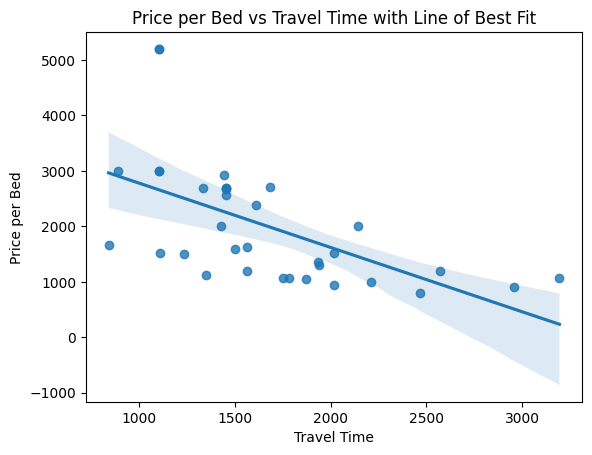

In [97]:
sns.regplot(x='travel_time', y='price_per_bed', data=reg_data)
plt.xlabel('Travel Time')
plt.ylabel('Price per Bed')
plt.title('Price per Bed vs Travel Time with Line of Best Fit')
plt.show()

### Make Predictions of Rent Per Bed to See Which Flats are Underpriced

#### Make the Predictions

In [98]:
# Select features and target
X = reg_data[['travel_time', 'bathrooms']]
y = reg_data['price_per_bed']

# Create and fit model
model = LinearRegression()
model.fit(X, y)

# To generate predictions 
predictions = model.predict(X)

# Add predictions to dataframe
reg_data.loc[:,'predicted_price_per_bed'] = predictions





#### Save out the Data With Predictions

In [99]:
# Save the filled-in dataframe into the pre-existing table, replacing the incomplete with the complete data
sqlq.make_table(reg_data, "properties_data", engine, if_exists='replace')